<a href="https://colab.research.google.com/github/RG2806/ai_spotle/blob/master/level3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn import model_selection, preprocessing, metrics, svm, ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
!git clone https://github.com/RG2806/ai_spotle.git

Cloning into 'ai_spotle'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 4115 (delta 33), reused 33 (delta 29), pack-reused 4066
Receiving objects: 100% (4115/4115), 49.92 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (4088/4088), done.


In [3]:
!git clone https://github.com/lukasgarbas/nlp-text-emotion.git

Cloning into 'nlp-text-emotion'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 44 (delta 13), reused 36 (delta 6), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [4]:
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [5]:
data_train = pd.read_csv('/content/nlp-text-emotion/data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/nlp-text-emotion/data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [6]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [7]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12088


In [10]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10259,   173,    13]], dtype=int32)

In [11]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [13]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [14]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [15]:
embedd_matrix = create_embedding_matrix('/content/embeddings/wiki-news-300d-1M.vec', index_of_words, embed_num_dims)
embedd_matrix.shape

(12089, 300)

In [16]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 646


In [17]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [18]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
batch_size = 256
epochs = 50

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

In [22]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['delivery was hour late and my pizza was cold!']
predicted: fear (0.05 seconds)


In [37]:
import pandas as pd

import os
##combine all files in the lis
#df=pd.read_json("/content/ai_spotle/aithon2020_level_3/aithon_level_3_2020-09-22T05_11_55.txt")
df = pd.concat([pd.read_json("/content/ai_spotle/aithon2020_level_3/"+f) for c,f in enumerate(os.listdir("/content/ai_spotle/aithon2020_level_3/")) ])

In [38]:
df.shape

(496448, 4)

In [39]:
tok = WordPunctTokenizer()
lemma = WordNetLemmatizer()
# patterns to remove html tags numbers and special Characters
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
op = r'\bcovid\b\s+'
combined_pat = r'|'.join((pat1, pat2))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
shortcuts = {'u': 'you', 'y': 'why', 'r': 'are', 'doin': 'doing', 'hw': 'how', 'k': 'okay', 'm': 'am', 'b4': 'before',
            'idc': "i do not care", 'ty': 'thankyou', 'wlcm': 'welcome', 'bc': 'because', '<3': 'love', 'xoxo': 'love',
            'ttyl': 'talk to you later', 'gr8': 'great', 'bday': 'birthday', 'awsm': 'awesome', 'gud': 'good', 'h8': 'hate',
            'lv': 'love', 'dm': 'direct message', 'rt': 'retweet', 'wtf': 'hate', 'idgaf': 'hate',
             'irl': 'in real life', 'yolo': 'you only live once'}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
shortcuts_pattern = re.compile(r'\b(' + '|'.join(shortcuts.keys()) + r')\b')
def clean_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)#for removing patterns like #,@ and punctuation
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    shortcuts_handled = shortcuts_pattern.sub(lambda x: shortcuts[x.group()],neg_handled)
    letters_only = re.sub("[^a-zA-Z]", " ", shortcuts_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    lemmated_words = [lemma.lemmatize(word) for word in words]
    return (" ".join( lemmated_words)).strip()

In [40]:
df=df[df['location'].apply(lambda x: x.lower().find("india")>-1)]
df['cleaned_tweets'] = df['text'].apply(lambda x: clean_text(x))

In [41]:
df.head()

,text,location,date,time,cleaned_tweets
1,@plenkless @talkRADIO @JuliaHB1 You really think @CMO_England and @uksciencechief have more of an idea ? They still say 92% of the population are susceptible to Covid 19 despite evidence on TCells and cross immunity with other Corona viruses. They appear to have learned nothing!,India,Sep 22,11:29:59,you really think and have more of an idea they still say of the population are susceptible to covid despite evidence on tcells and cross immunity with other corona virus they appear to have learned nothing
13,Know how #wearabledevices can prove useful in the fight against #Corona disease https://t.co/ajQQxyVrGL by Andrew Steger via @CDW_Healthcare\n\n#healthcare #coronavirus #wearables #fitbit #fitnesstrackers #fitness #mistralsolutions,India,Sep 22,11:19:16,know how wearabledevices can prove useful in the fight against corona disease by andrew steger via healthcare coronavirus wearable fitbit fitnesstrackers fitness mistralsolutions
27,Australia-The Corona Virus: A Pandemic?\nhttps://t.co/vMQcobzlGo\n#Covid #COVID19 #pandemic #lockdown #virus #coronavirus #MaskOn #Australia,"Hyderabad, India",Sep 22,11:08:59,australia the corona virus pandemic covid pandemic lockdown virus coronavirus maskon australia
32,Now Both are Corona Positive after this video 😂😂\n#Covid_19 #Coroanvirus https://t.co/E0vrUNz3ae,"New Delhi, India",Sep 22,11:04:41,now both are corona positive after this video covid coroanvirus
33,"@afneil Andrew, could you ask the Government if the tests show positive for all types of Corona Virus or can it isolate Covid 19?","Mysuru,India",Sep 22,11:04:28,andrew could you ask the government if the test show positive for all type of corona virus or can it isolate covid


In [42]:
df.shape

(84246, 5)

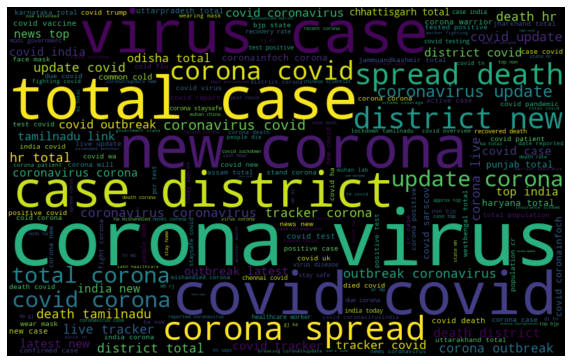

In [43]:
all_words = ' '.join([text for text in df['cleaned_tweets']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [44]:
def check(s):
  message = [s]
  seq = tokenizer.texts_to_sequences(message)
  padded = pad_sequences(seq, maxlen=max_seq_len)
  pred = model.predict(padded)
  return class_names[np.argmax(pred)]
df['analysis'] = df['cleaned_tweets'].apply(lambda x : check(x))

In [45]:
df.head()

,text,location,date,time,cleaned_tweets,analysis
1,@plenkless @talkRADIO @JuliaHB1 You really think @CMO_England and @uksciencechief have more of an idea ? They still say 92% of the population are susceptible to Covid 19 despite evidence on TCells and cross immunity with other Corona viruses. They appear to have learned nothing!,India,Sep 22,11:29:59,you really think and have more of an idea they still say of the population are susceptible to covid despite evidence on tcells and cross immunity with other corona virus they appear to have learned nothing,anger
13,Know how #wearabledevices can prove useful in the fight against #Corona disease https://t.co/ajQQxyVrGL by Andrew Steger via @CDW_Healthcare\n\n#healthcare #coronavirus #wearables #fitbit #fitnesstrackers #fitness #mistralsolutions,India,Sep 22,11:19:16,know how wearabledevices can prove useful in the fight against corona disease by andrew steger via healthcare coronavirus wearable fitbit fitnesstrackers fitness mistralsolutions,fear
27,Australia-The Corona Virus: A Pandemic?\nhttps://t.co/vMQcobzlGo\n#Covid #COVID19 #pandemic #lockdown #virus #coronavirus #MaskOn #Australia,"Hyderabad, India",Sep 22,11:08:59,australia the corona virus pandemic covid pandemic lockdown virus coronavirus maskon australia,neutral
32,Now Both are Corona Positive after this video 😂😂\n#Covid_19 #Coroanvirus https://t.co/E0vrUNz3ae,"New Delhi, India",Sep 22,11:04:41,now both are corona positive after this video covid coroanvirus,joy
33,"@afneil Andrew, could you ask the Government if the tests show positive for all types of Corona Virus or can it isolate Covid 19?","Mysuru,India",Sep 22,11:04:28,andrew could you ask the government if the test show positive for all type of corona virus or can it isolate covid,neutral


In [46]:
df.to_csv('filterd.csv',index=False)

In [51]:
class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']
df[df.analysis=='anger'].head(10)

,text,location,date,time,cleaned_tweets,analysis
1,@plenkless @talkRADIO @JuliaHB1 You really think @CMO_England and @uksciencechief have more of an idea ? They still say 92% of the population are susceptible to Covid 19 despite evidence on TCells and cross immunity with other Corona viruses. They appear to have learned nothing!,India,Sep 22,11:29:59,you really think and have more of an idea they still say of the population are susceptible to covid despite evidence on tcells and cross immunity with other corona virus they appear to have learned nothing,anger
211,"cw // covid , food\n\nhey besties i did the corona test and now imnat my uncles restaurant 👍🏻👍🏻","Balotra, India",Sep 22,08:45:45,cw covid food hey besties did the corona test and now imnat my uncle restaurant,anger
295,"corona vaccination: 4 out of 10 French citizens would refuse vaccine- Ipsos - A new Ipsos poll has found that 4 out 10 French citizens would refuse a COVID-19 vaccination if it were available. According to the survey,… Read... https://t.co/Mah0ATePll https://t.co/ywvw8YnyNa","jhansi Uttar Pradesh, India",Sep 22,07:28:43,corona vaccination out of french citizen would refuse vaccine ipsos new ipsos poll ha found that out french citizen would refuse covid vaccination if it were available according to the survey read,anger
302,Due to COVID we don’t have cones; but we can still have ice cream. 😋🍦 #NationalIceCreamConeDay #CardinaleWayMazdaCorona\n\nWhat is your favorite kind of cone? COMMENT BELOW ⬇️ https://t.co/eb4atfg9qu,"Punjab, India",Sep 22,07:27:03,due to covid we don have cone but we can still have ice cream nationalicecreamconeday cardinalewaymazdacorona what is your favorite kind of cone comment below,anger
362,"@jsolomonReports @TrueNPatriot -\n\nFor anyone who does not know why the Corona Virus was \n\nrenamed to Covid 19, you can just thank the White Hats.\n\nhttps://t.co/Q79ahwTucA…\n\n-",India,Sep 22,06:36:58,for anyone who doe not know why the corona virus wa renamed to covid you can just thank the white hat,anger
369,The purpose of a Green Democratic Transformation is the protection of society and its material conditions of existence in a way that empowers people\n\nChantal Mouffe @ChantalMouffe\n\nA Left populist Strategy for Post-COVID-19\n\nhttps://t.co/zHSRp61R78\n\n#GreenNewDeal #COVID19 #Corona https://t.co/MlFxuQhMnE,"Ahmadabad City, India",Sep 22,06:32:37,the purpose of green democratic transformation is the protection of society and it material condition of existence in way that empowers people chantal mouffe left populist strategy for post covid covid corona,anger
432,@Suriya_offl @krishoffl @SonyMusicSouth @kavingarmadhan @thisispriyamali @sirajkhan_skp @barani_offl @balaji_indian Please look into the issue.\n\nShe was found Corona positive after giving neet and she is no longer with us.\n\nStudents having low immunity were forced to give exams. \n\nParliament was shortened due to COVID.\n\nBut no one cares for students and parents. https://t.co/ZlWjHqCnV8,India,Sep 22,05:37:55,please look into the issue she wa found corona positive after giving neet and she is no longer with u student having low immunity were forced to give exam parliament wa shortened due to covid but no one care for student and parent,anger
443,I'm just no getting this Corona/Covid virus thing. I see the majority of people abide by the rules in every capacity yet this thing is apparently getting worse. If so it has to be airborne in the atmosphere. Nothing to do with 2m distance or whatever. It's just no adding up🤔👎,India,Sep 22,05:30:06,am just no getting this corona covid virus thing see the majority of people abide by the rule in every capacity yet this thing is apparently getting worse if so it ha to be airborne in the atmosphere nothing to do with distance or whatever it just no adding up,anger
521,"today's India #corona cases are 55 lakhs , \nkishan reddy things 54.98 lakh Indians went &amp; hugged and kissed tablighis to infect themselves of #covid !!!

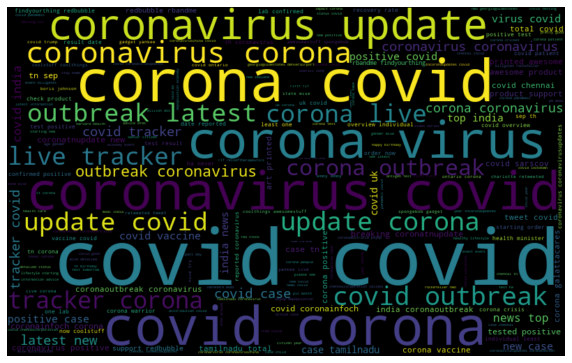

In [48]:
normal_words =' '.join([text for text in df['cleaned_tweets'][df['analysis'] == 'joy']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()